In [2]:
# Mount Google Drive to access and store files in '/content/gdrive'
# from google.colab import drive
# drive.mount('/content/gdrive')

In [1]:
# Change working directory
import os
# TODO: Specify your path here
# new_directory = "/content/gdrive/Othercomputers/Mein MacBook Pro/Drive/dl_proj"
# os.chdir(new_directory)
# print("Current Working Directory:", os.getcwd())

In [2]:
# imports
import torch
from torch.nn import CrossEntropyLoss
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from utils.metrics import topk_acc, real_acc, AverageMeter

from models.networks import get_model
from data_utils.data_stats import *

import matplotlib.pyplot as plt

In [3]:
dataset = 'cifar10'                 # One of cifar10, cifar100, stl10, imagenet or imagenet21
architecture = 'B_12-Wi_1024'
data_resolution = 32                # Resolution of data as it is stored
crop_resolution = 64                # Resolution of fine-tuned model (64 for all models we provide)
num_classes = CLASS_DICT[dataset]
#data_path = './beton/'
eval_batch_size = 1024
checkpoint = 'in21k_cifar10'        # This means you want the network pre-trained on ImageNet21k and finetuned on CIFAR10

In [62]:
# TODO: Do not forget to choose GPU as runtime
torch.backends.cuda.matmul.allow_tf32 = True
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# TODO: Create a folder called 'checkpoints'. It is already included in the .gitignore file
# Define the model and specify the pre-trained weights
model = get_model(architecture=architecture, resolution=crop_resolution, num_classes=num_classes, checkpoint=checkpoint)

# from cifar10_models.resnet import *
# model = resnet18()

# model.cuda()

Weights already downloaded
Load_state output <All keys matched successfully>


In [6]:
weights = torch.load('state_dicts/resnet18.pt')
model.load_state_dict(weights)

<All keys matched successfully>

In [63]:
mean = (0.4914, 0.4822, 0.4465)
std = (0.2471, 0.2435, 0.2616)

transform = transforms.Compose([
    transforms.Resize((crop_resolution, crop_resolution)),
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

In [64]:
# ./data folder is ot uploaded to Github. See .gitignore
cifar10_dataset = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
loader = DataLoader(cifar10_dataset, batch_size=eval_batch_size, shuffle=True)


cifar10_classes = [
    'airplane', 'automobile', 'bird', 'cat', 'deer',
    'dog', 'frog', 'horse', 'ship', 'truck'
]

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


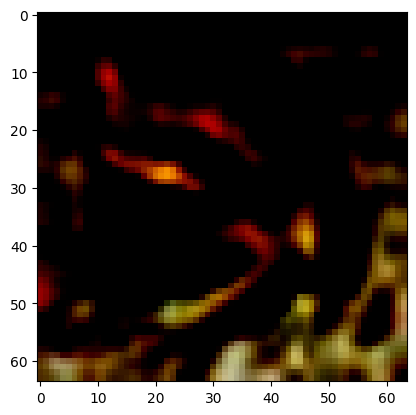

In [65]:
# select test image
image_nr = 300

# display image
image, true_label = cifar10_dataset[image_nr]
image = image.numpy().transpose((1, 2, 0))
plt.imshow(image)
plt.show()

# prepare image to be processed by model
image, _ = cifar10_dataset[image_nr]
image = image.unsqueeze(0)
image = image.view(-1)
# image = image.cuda()

In [66]:
image.shape

torch.Size([1, 3, 64, 64])

In [67]:
model.eval()

with torch.no_grad():
    output = model(image)
    # print("Shape of the output tensor:", output.shape)

probabilities = torch.nn.functional.softmax(output, dim=1)
predicted_class = torch.argmax(probabilities).item()

predicted_label = cifar10_classes[predicted_class]
tr_label = cifar10_classes[true_label]

print(f"Model prediction:", predicted_label)
print(f"True label:      ", tr_label)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (192x64 and 12288x1024)

In [54]:
torch.nn.functional.softmax(output, dim=1)

tensor([[1.0578e-03, 1.0380e-03, 1.8290e-03, 2.0334e-03, 1.4107e-03, 1.2752e-03,
         9.8822e-01, 9.8770e-04, 1.0458e-03, 1.1029e-03]])

In [52]:
output.shape

torch.Size([1, 10])

In [53]:
output

tensor([[-0.8459, -0.8647, -0.2983, -0.1923, -0.5580, -0.6590,  5.9939, -0.9144,
         -0.8572, -0.8041]])

In [34]:
from utils.parsers import get_training_parser

parser = get_training_parser()
args = parser.parse_args(args=[])

In [35]:
loss_fn = CrossEntropyLoss(label_smoothing=args.smooth)

In [36]:
import time
from tqdm import tqdm
start = time.time()
model.eval()
total_acc, total_top5, total_loss = AverageMeter(), AverageMeter(), AverageMeter()

for ims, targs in tqdm(loader, desc="Evaluation"):
    targs = targs # .cuda()
    # ims = torch.reshape(ims, (ims.shape[0], -1))# .cuda()
    preds = model(ims)

    if args.dataset != 'imagenet_real':
        acc, top5 = topk_acc(preds, targs, k=5, avg=True)
        loss = loss_fn(preds, targs).item()
    else:
        acc = real_acc(preds, targs, k=5, avg=True)
        top5 = 0
        loss = 0

    total_acc.update(acc, ims.shape[0])
    total_top5.update(top5, ims.shape[0])
    total_loss.update(loss)

end = time.time()

Evaluation: 100%|██████████| 10/10 [00:29<00:00,  2.94s/it]


In [37]:
#print("Epoch", ep, "       Time:", train_time)
#print("-------------- Training ----------------")
#print("Average Training Loss:       ", "{:.6f}".format(train_loss))
#print("Average Training Accuracy:   ", "{:.4f}".format(train_acc))
#print("Top 5 Training Accuracy:     ", "{:.4f}".format(train_top5))
print("---------------- Test ------------------")
print("Test Accuracy        ", "{:.4f}".format(total_acc.get_avg(percentage=True)))
print("Top 5 Test Accuracy          ", "{:.4f}".format(total_top5.get_avg(percentage=True)))
print()

---------------- Test ------------------
Test Accuracy         93.0700
Top 5 Test Accuracy           99.7400



In [22]:
targs.shape

torch.Size([784])

In [27]:
targs.min()

tensor(0, device='cuda:0')

In [28]:
for ims, targs in tqdm(loader, desc="Evaluation"):
    break

Evaluation:   0%|          | 0/10 [00:00<?, ?it/s]


In [29]:
ims.shape

torch.Size([1024, 3, 64, 64])

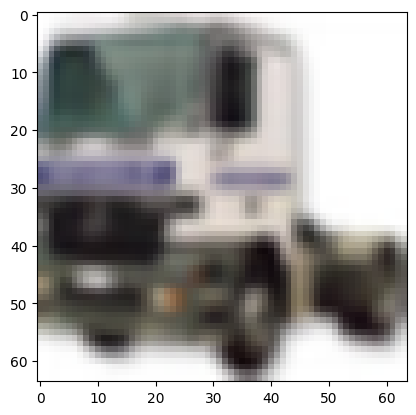

In [30]:
plt.imshow(ims[0].detach().numpy().transpose(1,2,0))

In [31]:
ims[0]

tensor([[[1.0000, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9922, 0.9686,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [1.0000, 1.0000, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9922, 0.9686,  ..., 0.9961, 0.9961, 0.9961],
         ...,
         [1.0000, 1.0000, 0.9961,  ..., 0.9961, 0.9961, 0.9961],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 1.0000, 0.9961,  ..., 1.0000, 1.0000, 1.0000]],

        [[1.0000, 0.9961, 0.9922,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9961, 0.9843,  ..., 1.0000, 1.0000, 1.0000],
         [1.0000, 0.9922, 0.9686,  ..., 0.9961, 0.9961, 0.

In [26]:
1228/64

19.1875